# Pairs Trading
* Pairs trading is a market-neutral strategy that involves taking simultaneous long and short positions in two historically cointegrated securities to profit from their temporary price divergence and subsequent mean reversion.
* Pairs trading is **market-neutral** because it profits in virtually any market condition: uptrend, downtrend, or sideways movement. This is because the strategy involves taking both long and short positions, balancing exposure to broader market movements.

# Mathematical Foundation

Pairs trading relies on statistical and econometric techniques:
* A time series $y_t$ is integrated of order 1, or $I(1)$, when a single differencing removes non-stationarity.
* A time series that does not need to be differenced to be stationary is $I(0)$.
* Price data can be assumed as $I(1)$ time series, while returns can be assumed as $I(0)$ series.
* $I(0)$ time series have an important property that allows us to create a mean-reverting strategy: the mean and variance of $I(0)$ time series are finite and do not change with time. This time-invariant property implies that the behavior of the time series is predictable: if the time series wanders too far away from the mean, the time-invariant property will “drag” the series back to make sure the mean does not change.
* **Cointegration** is the statistical property where two or more time series move together over time, indicating a stable long-term relationship. Mathematically, two times series $x_t$ and $y_t$ are cointegrated, if $x_t$ and $y_t$ are $I(1)$ series and there exists $\beta$ such that $z_t = x_t - \beta y_t$ is an $I(0)$ series.
* **Engle-Granger test** performs a linear regression between the two asset prices and check if the residual is stationary using the Augmented Dick-Fuller (ADF) test. If the residual is stationary, then the two asset prices are cointegrated. The cointegration coefficient is obtained as the coefficient of the regressor.


# Z-score
**Z-score** is a statistical measurement that describes a value's relationship to the mean of a group of values. In practice, it indicates how many standard deviations an element is from the mean. In pairs trading, z-scores help identify extreme deviations from the mean spread. The z-score is calculated as follows:

$$
Z = \frac{X - \mu}{\sigma}
$$

Where:
- $Z$ is the Z-score,
- $ X $ is a series of spread values,
- $ \mu $ is the mean of the spread,
- $ \sigma $ is the standard deviation of the spread.

# Trading Strategy Based on Pairs Trading

1. To create a trading strategy based on pairs trading, we first need to find a cointegrated pair. Cointegration is an important property for pairs trading because it allows us to construct a stationary time series from two asset price series by finding the cointegration coefficient $\beta$. In our case, we will trade *GOOG* and *GOOGL*, stock ticker symbols for Alphabet. The choice of GOOG and GOOGL is logical because they represent different share classes of Alphabet with a high likelihood of being cointegrated due to the underlying economic link. The main difference between the *GOOG* and *GOOGL* stock ticker symbols is that *GOOG* shares have no voting rights, while *GOOGL* shares do.
2. First, we test the price series of *GOOG* and *GOOGL* for cointegration. This step ensures that the assets have a stable long-term relationship necessary for pairs trading.
3. Next, we fit Linear Regression model on using the past *GOOGL* prices (target) against GOOG prices (independent variable) in order to determine the cointegration coefficient $\beta$. This coefficient is used to create a stationary spread.
4. This spread should be stationary if the assets are cointegrated, making it possible to identify deviations from the mean. The spread between *GOOG* and *GOOGL* is calculated as follows:

$$
Spread = P_{GOOGL} - \beta P_{GOOG}
$$

5. Entry and exit rules based on z-score thresholds are standard in pairs trading. The z-score of the spread helps normalize the spread and identify deviations from its mean.  We calculate the z-score of the spread and define the entry and exit rules:

* Long GOOGL if $\text{z-score}_{spread} < -\text{entry threshold}$
* Short GOOGL if $\text{z-score}_{spread} > \text{entry threshold}$
* Exit if $|\text{z-score}_{spread}| < \text{exit threshold}$

# Optimizing Exit and Entry Thresholds
We perform a simple grid search to identify optimal exit and entry thresholds. To do so, we define a validation set and backtest our trading strategy using this set. Then, we get the exit and entry thresholds that led either to the highest return or highest sharpe ratio and we evaluate how our strategy performs using a test set.

# Baseline
To compare the performance of our strategy, we compare it against S&P 500 performance.

# Implementation

First, we import the libraries and load historical data for GOOG and GOOGL.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import coint
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [ ]:
# Define the start date for downloading historical stock data
start_date = '2015-01-01'

# Define the start date for the validation period
validation_start_date = '2020-01-01'

# Define the start and end dates for the backtesting period
backtest_start_date = '2022-01-01'
backtest_end_date = '2024-01-01'

# Define the stock ticker symbols for the assets to be analyzed
ticker1 = 'GOOG'   # Alphabet Inc. Class C shares (non-voting)
ticker2 = 'GOOGL'  # Alphabet Inc. Class A shares (voting)

# Define the figure size for plotting
figsize = (12, 6)

In [ ]:
# Download adjusted close prices for the first stock (GOOG) from Yahoo Finance
data1 = yf.download(ticker1, start=start_date, end=backtest_end_date)['Adj Close']

# Download adjusted close prices for the second stock (GOOGL) from Yahoo Finance
data2 = yf.download(ticker2, start=start_date, end=backtest_end_date)['Adj Close']

# Download adjusted close prices for the baseline (SPY, S&P 500 ETF) from Yahoo Finance
baseline_data = yf.download('SPY', start=start_date, end=backtest_end_date)['Adj Close']

# Combine the data for both stocks into a single DataFrame
data = pd.DataFrame({ticker1: data1, ticker2: data2})

# Remove any rows with missing values
data.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Split the data into a training set (up to the start of the validation period)
data_past = data.loc[:validation_start_date]

# Split the data into a validation set (from the start of the validation period to the start of the backtesting period)
data_validation = data.loc[validation_start_date:backtest_start_date]

# Split the data into a backtesting set (from the start of the backtesting period to the end of the backtesting period)
data_backtest = data.loc[backtest_start_date:backtest_end_date]

In [ ]:
def get_sharpe_ratio(daily_rets):
    rf = 0.02  # Risk-free rate (annual)
    cumrets = daily_rets.cumprod()  # Cumulative returns
    annual_rets = cumrets.iloc[-1]**(252/len(cumrets)) - 1  # Annualized returns
    annual_std = daily_rets.std() * np.sqrt(252)  # Annualized standard deviation
    sharpe_ratio = (annual_rets - rf) / annual_std  # Sharpe ratio

    return sharpe_ratio.round(2)

In [ ]:
# Calculate daily returns for the baseline (SPY) during different periods
baseline_rets_past = baseline_data.loc[start_date:validation_start_date].pct_change().add(1).fillna(1)
baseline_rets_validation = baseline_data.loc[validation_start_date:backtest_start_date].pct_change().add(1).fillna(1)
baseline_rets_backtest = baseline_data.loc[backtest_start_date:backtest_end_date].pct_change().add(1).fillna(1)

# Calculate cumulative returns for the baseline during different periods
baseline_cumrets_past = baseline_rets_past.cumprod()
baseline_cumrets_validation = baseline_rets_validation.cumprod()
baseline_cumrets_backtest = baseline_rets_backtest.cumprod()

# Calculate the Sharpe ratio for the baseline during different periods
baseline_sr_past = get_sharpe_ratio(baseline_rets_past)
baseline_sr_validation = get_sharpe_ratio(baseline_rets_validation)
baseline_sr_backtest = get_sharpe_ratio(baseline_rets_backtest)

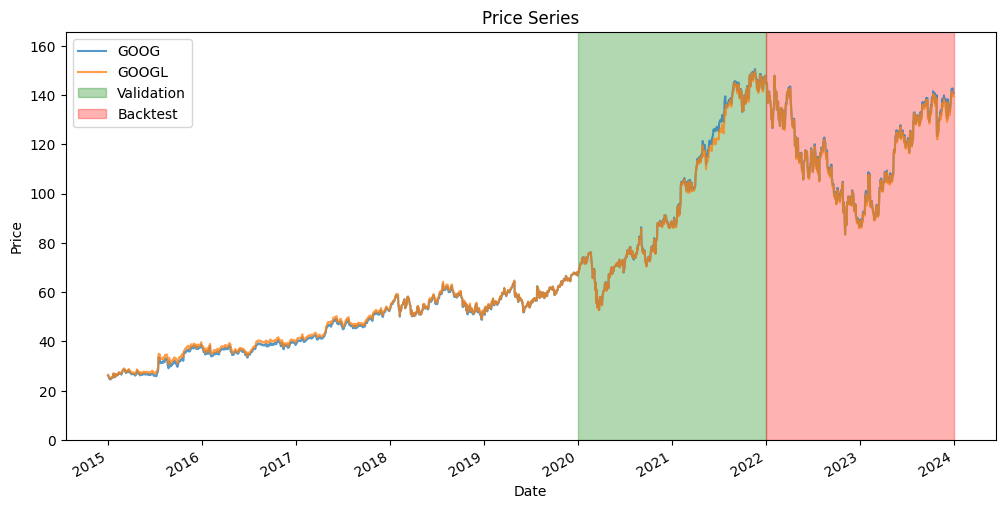

In [ ]:
# Plot the price series for both tickers
data.plot(figsize=figsize, alpha=.75)  # Plot the data with specified figure size and transparency

# Define the maximum y-axis limit with a 10% buffer
max_y = data.max().max() * 1.1

# Highlight the validation period in green with some transparency
plt.axvspan(validation_start_date, backtest_start_date, 0, max_y, color='g', alpha=0.3, label='Validation')

# Highlight the backtesting period in red with some transparency
plt.axvspan(backtest_start_date, data.index.max(), 0, max_y, color='r', alpha=0.3, label='Backtest')

# Set the y-axis limit to include the buffer
plt.ylim(0, max_y)

# Add plot title and axis labels
plt.title('Price Series')
plt.ylabel('Price')
plt.xlabel('Date')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

# Engle-Granger Cointegration Test
The p-value indicates whether the two time series are cointegrated. A small p-value (typically below 0.05) suggests cointegration.

In [ ]:
# Perform the Engle-Granger cointegration test on the past data for the two tickers
score, p_value, _ = coint(data_past[ticker1], data_past[ticker2])

# Print the p-value of the cointegration test, rounded to two decimal places
print(f'Cointegration test p-value: {p_value:.2}')
if p_value < 0.05:
    print('The two time series are cointegrated.')
else:
    print('The two time series are not cointegrated.')

Cointegration test p-value: 0.045
The two time series are cointegrated.


In [ ]:
# Reshape the price data for ticker1 to be used as the independent variable (X) in the linear regression model
X_past = data_past[ticker1].values.reshape(-1, 1)

# Extract the price data for ticker2 to be used as the dependent variable (y) in the linear regression model
y_past = data_past[ticker2].values

# Fit a linear regression model with ticker1 prices as the predictor and ticker2 prices as the target
model = LinearRegression().fit(X_past, y_past)

# Calculate the spread as the difference between the actual prices of ticker2 and the predicted values from the model
spread_past = y_past - model.predict(X_past)

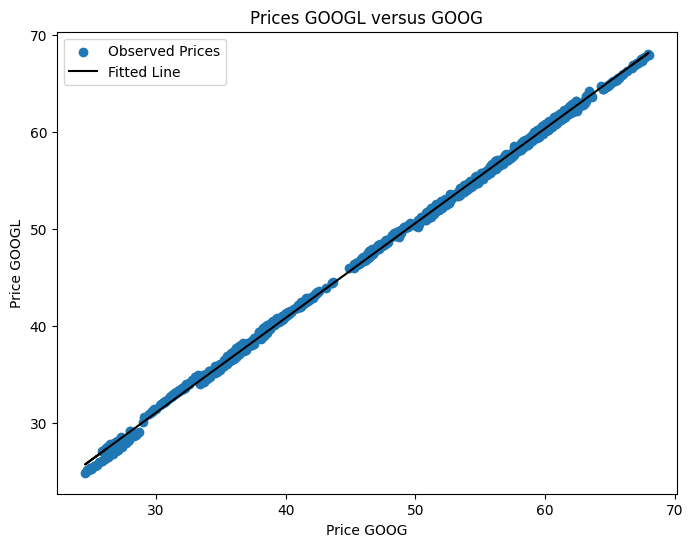

In [ ]:
# Plot a scatter plot of prices for ticker1 versus ticker2
plt.figure(figsize=(8,6))
plt.scatter(X_past, y_past, label='Observed Prices')
plt.xlabel(f'Price {ticker1}')
plt.ylabel(f'Price {ticker2}')
plt.title('Prices GOOGL versus GOOG')
plt.plot(X_past, model.predict(X_past), color='k', label='Fitted Line')
plt.legend()
plt.show()

In [ ]:
# Use the model to calculate the spread during validation
X_val = data_validation[ticker1].values.reshape(-1, 1)
y_val = data_validation[ticker2].values
spread_validation = y_val - model.predict(X_val)

In [ ]:
# Use the model to calculate the spread during backtest
X_backtest = data_backtest[ticker1].values.reshape(-1, 1)
y_backtest = data_backtest[ticker2].values
spread_backtest = y_backtest - model.predict(X_backtest)

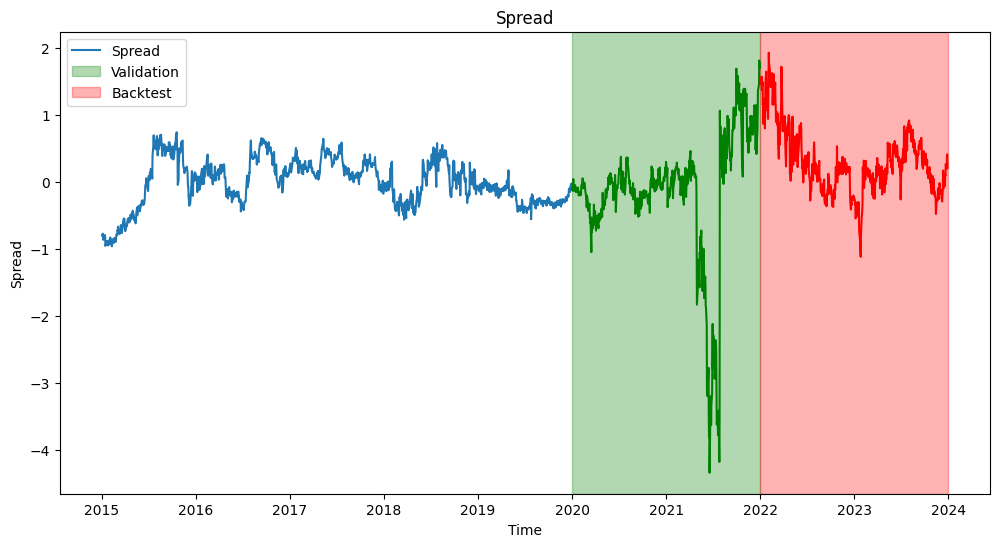

In [ ]:
# Determine the maximum y-axis limit for the spread plot
max_y = max(spread_past.max(), spread_validation.max(), spread_backtest.max())

# Create a figure with specified size
plt.figure(figsize=figsize)

# Plot the spread for different periods
plt.plot(data_past[ticker1].index, spread_past, label='Spread')
plt.plot(data_validation[ticker1].index, spread_validation, c='g')
plt.plot(data_backtest[ticker1].index, spread_backtest, c='r')

# Highlight the validation and backtesting periods
plt.axvspan(validation_start_date, backtest_start_date, 0, max_y, color='g', alpha=0.3, label='Validation')
plt.axvspan(backtest_start_date, data.index.max(), 0, max_y, color='r', alpha=0.3, label='Backtest')

# Display labels, title, and legend
plt.ylabel('Spread')
plt.xlabel('Time')
plt.title('Spread')
plt.legend()
plt.show()

In [ ]:
# Calculate the z-score for a given series
# !!! Note that we must use the spread calculated using past data at time t !!!
# !!! Because this is the data that we have available at time t+1 !!!
def zscore(series):
    mean = spread_past.mean()  # Mean of the spread in the past
    std = spread_past.std()    # Standard deviation of the spread in the past
    return (series - mean) / std  # Z-score calculation

# Visualizing Exit and Entry Thresholds
Let's visualize the exit and entry thresholds of our strategy.

In [ ]:
# Define possible exit and entry thresholds
exit_threshold = 0.5
entry_threshold = 2.0

In [ ]:
def generate_signals(dataframe, spread, entry_threshold, exit_threshold):
    # Calculate the z-score of the spread
    zscore_spread = zscore(spread)

    # Create a copy of the dataframe and add columns for signals
    dataframe = dataframe.copy()
    dataframe['Z-Score'] = zscore_spread
    dataframe['Long Signal'] = dataframe['Z-Score'] < -entry_threshold
    dataframe['Short Signal'] = dataframe['Z-Score'] > entry_threshold
    dataframe['Exit Signal'] = abs(dataframe['Z-Score']) < exit_threshold

    return dataframe

In [ ]:
# Generate trading signals for the past and validation data
data_past = generate_signals(data_past, spread_past, entry_threshold, exit_threshold)
data_validation = generate_signals(data_validation, spread_validation, entry_threshold, exit_threshold)

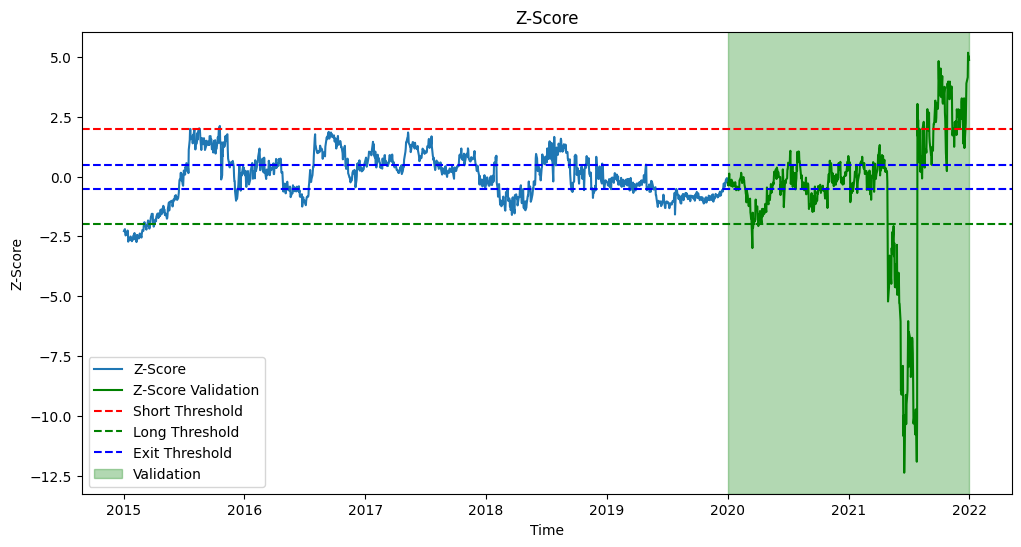

In [ ]:
# Plot the Z-Score for past and validation data
plt.figure(figsize=figsize)
plt.plot(data_past.index, data_past['Z-Score'], label='Z-Score')
plt.plot(data_validation.index, data_validation['Z-Score'], label='Z-Score Validation', c='g')

# Plot entry and exit thresholds
plt.axhline(entry_threshold, color='r', linestyle='--', label='Short Threshold')
plt.axhline(-entry_threshold, color='g', linestyle='--', label='Long Threshold')
plt.axhline(exit_threshold, color='b', linestyle='--', label='Exit Threshold')
plt.axhline(-exit_threshold, color='b', linestyle='--')

# Highlight the validation period
plt.axvspan(validation_start_date, backtest_start_date, 0, max_y, color='g', alpha=0.3, label='Validation')

# Labels, title, and legend
plt.ylabel('Z-Score')
plt.xlabel('Time')
plt.title('Z-Score')
plt.legend()
plt.show()

# Backtest
Next, we define our backtest function and check the performance of the strategy when using the exit and entry threshold that we defined above.

In [ ]:
def backtest(data, plot=False):
    positions = []

    # Generate trading signals and record positions
    for i in range(len(data)):
        if data['Long Signal'].iloc[i]:
            positions.append((data.index[i], 'Buy', ticker2, data[ticker2].iloc[i]))
        elif data['Short Signal'].iloc[i]:
            positions.append((data.index[i], 'Sell', ticker2, data[ticker2].iloc[i]))
        elif data['Exit Signal'].iloc[i] and len(positions) > 0:
            positions.append((data.index[i], 'Exit', ticker2, data[ticker2].iloc[i]))

    # Create a DataFrame of positions
    positions_df = pd.DataFrame(positions, columns=['Date', 'Action', 'Ticker', 'Price'])
    positions_df.set_index('Date', inplace=True)

    # Calculate returns and signals
    positions_df['Returns'] = positions_df['Price'].pct_change()
    positions_df['Signal'] = positions_df['Action'].replace({'Buy': 1, 'Sell': -1, 'Exit': 0}).shift(1)

    # Compute strategy returns and cumulative returns
    strategy_returns = positions_df.iloc[1:]['Returns'].mul(positions_df.iloc[1:]['Signal']).add(1)
    cumprod = strategy_returns.cumprod().asfreq('D').ffill()
    cumprod[data.index.min()] = 1
    cumprod = cumprod.sort_index().asfreq('D').ffill()
    sr_strategy = get_sharpe_ratio(strategy_returns)

    # Plot cumulative returns if requested
    if plot:
        plt.figure(figsize=figsize)
        plt.plot(cumprod, label=f'Pairs Trading {ticker2}-{ticker1} (Sharpe Ratio {sr_strategy:.2})')
        plt.ylabel('Cumulative Returns')
        plt.title('Cumulative Returns')
        plt.xlabel('Date')
        plt.legend()

    return cumprod, strategy_returns

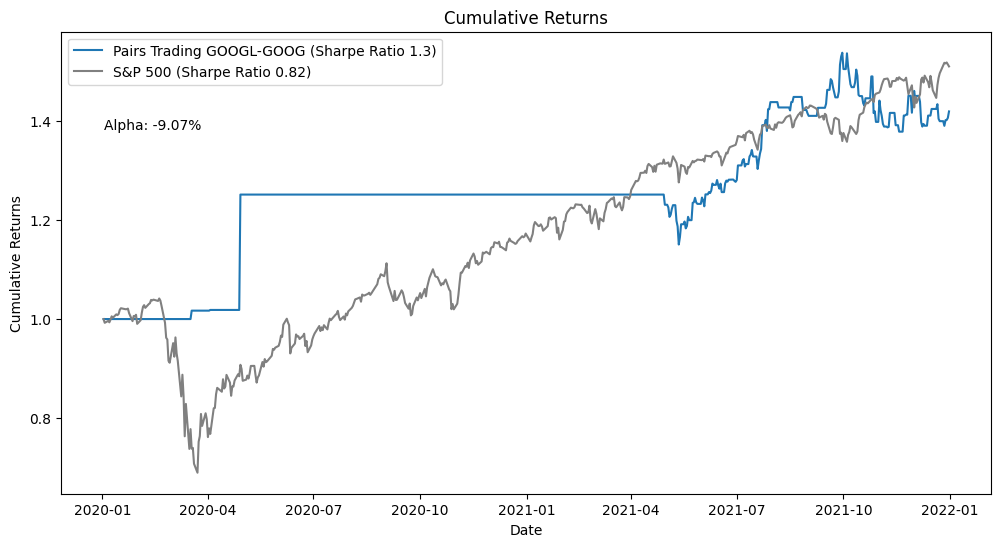

In [ ]:
# Run backtest on validation data and plot cumulative returns using the exit and entry threshold that we defined above
cumprod, strategy_return = backtest(data_validation, plot=True)

# Calculate alpha
alpha = cumprod.iloc[-1] - baseline_cumrets_validation.iloc[-1]

# Plot baseline cumulative returns (S&P 500) for comparison
plt.plot(baseline_cumrets_validation, label=f'S&P 500 (Sharpe Ratio {baseline_sr_validation})', c='gray')
plt.text(x=baseline_cumrets_validation.index.min(), y=max(cumprod.max(), baseline_cumrets_validation.max()) * 0.9, s=f'Alpha: {alpha:.2%}')
plt.legend()
plt.show()

# Finding Optimal Entry and Exit Thresholds

In [ ]:
# Define ranges for exit thresholds and multiples for entry threshold calculation
exit_thresholds = np.linspace(0, 0.5, 6).round(3)
multiples = [1, 2, 3, 4]

# Initialize a dictionary to store results
results_dict = {}

# Iterate over exit thresholds and entry threshold multiples
for exit_threshold in tqdm(exit_thresholds):
    for multiple in multiples:
        entry_threshold = (exit_threshold * multiple).round(2)

        # Generate trading signals for past and validation data
        data_past = generate_signals(data_past, spread_past, entry_threshold, exit_threshold)
        data_validation = generate_signals(data_validation, spread_validation, entry_threshold, exit_threshold)

        # Backtest the strategy on validation data
        cumprod, strategy_returns = backtest(data_validation, plot=False)

        # Calculate performance metrics
        cumprod_total_return = cumprod.iloc[-1]
        cumprod_daily_std = cumprod.std()
        cumprod_sharpe_ratio = cumprod_total_return / cumprod_daily_std

        # Store results in the dictionary
        results_dict[f'EXIT_{exit_threshold}-ENTRY_{entry_threshold}'] = {
            'total_return': cumprod_total_return,
            'daily_std': cumprod_daily_std,
            'sharpe_ratio': cumprod_sharpe_ratio,
            'exit_threshold': exit_threshold,
            'entry_threshold': entry_threshold
        }

# Convert results dictionary to a DataFrame
results_df = pd.DataFrame(results_dict).T

100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


# Backtest: Highest Total Return Strategy (Validation Set)

In [ ]:
# Sort the results by total return in descending order and display the top 3 rows
results_df.sort_values('total_return', ascending=False).head(3)

,total_return,daily_std,sharpe_ratio,exit_threshold,entry_threshold
EXIT_0.4-ENTRY_1.6,1.428238,0.133642,10.687040,0.4,1.6
EXIT_0.5-ENTRY_2.0,1.418445,0.131795,10.762501,0.5,2.0
EXIT_0.1-ENTRY_0.2,1.248287,0.153807,8.115940,0.1,0.2


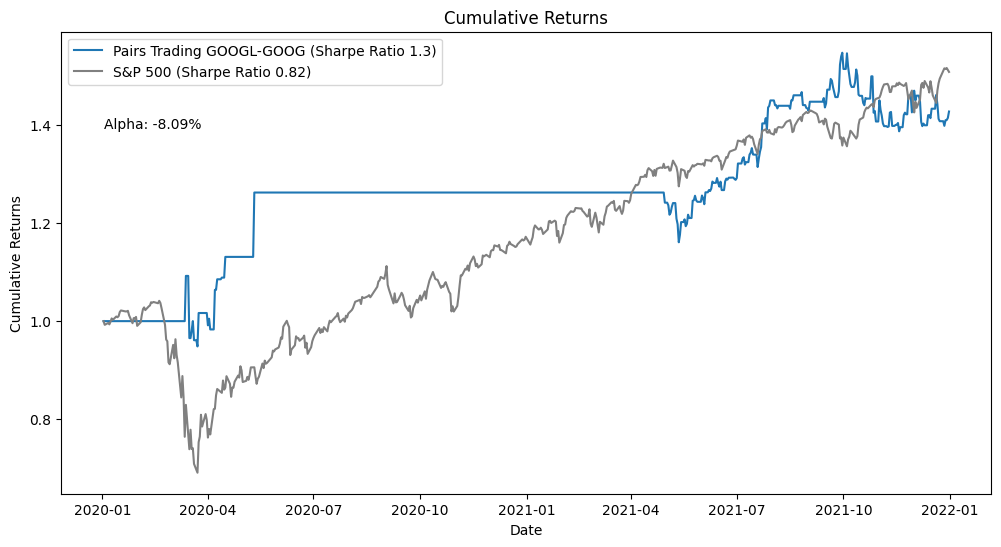

In [ ]:
# Get the exit and entry thresholds corresponding to the highest total return
highest_returns_exit = results_df.sort_values('total_return', ascending=False).iloc[0]['exit_threshold']
highest_returns_entry = results_df.sort_values('total_return', ascending=False).iloc[0]['entry_threshold']

# Generate trading signals for past and validation data using the thresholds that led to the highest total return
data_past = generate_signals(data_past, spread_past, highest_returns_entry, highest_returns_exit)
data_validation = generate_signals(data_validation, spread_validation, highest_returns_entry, highest_returns_exit)

# Backtest the strategy on validation data and plot cumulative returns
cumprod, strategy_returns = backtest(data_validation, plot=True)

# Calculate alpha
alpha = cumprod.iloc[-1] - baseline_cumrets_validation.iloc[-1]

# Plot baseline cumulative returns (S&P 500) for comparison
plt.plot(baseline_cumrets_validation, label=f'S&P 500 (Sharpe Ratio {baseline_sr_validation})', c='gray')
plt.text(x=baseline_cumrets_validation.index.min(), y=max(cumprod.max(), baseline_cumrets_validation.max()) * 0.9, s=f'Alpha: {alpha:.2%}')
plt.legend()
plt.show()

# Backtest: Highest Sharpe Ratio Strategy (Validation Set)

In [ ]:
# Sort the results by sharpe ratio in descending order and display the top 3 rows
results_df.sort_values('sharpe_ratio', ascending=False).head(3)

,total_return,daily_std,sharpe_ratio,exit_threshold,entry_threshold
EXIT_0.4-ENTRY_0.8,0.992999,0.060556,16.398059,0.4,0.8
EXIT_0.2-ENTRY_0.8,1.117021,0.077815,14.354914,0.2,0.8
EXIT_0.4-ENTRY_1.2,1.169260,0.083173,14.058164,0.4,1.2


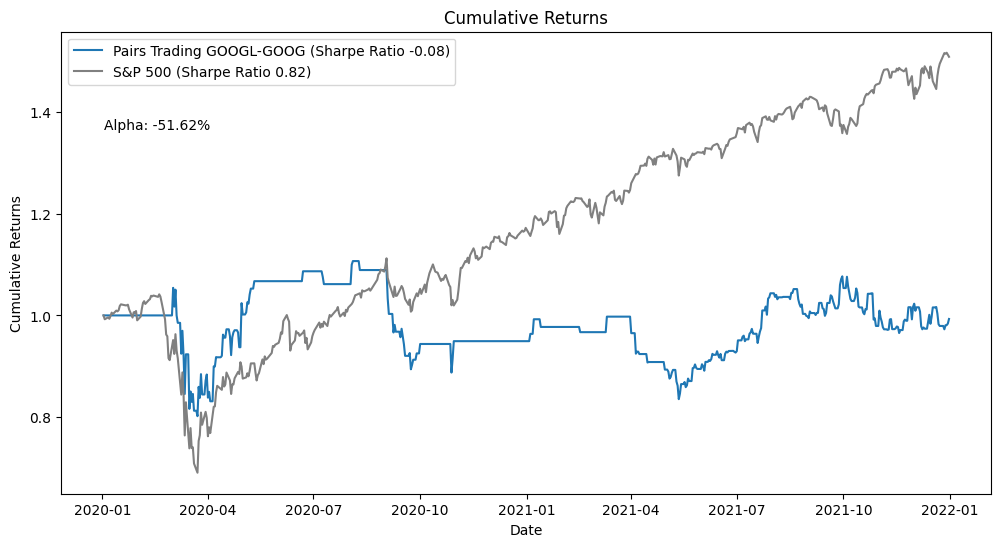

In [ ]:
# Get the exit and entry thresholds corresponding to the highest sharpe ratio
highest_sr_exit = results_df.sort_values('sharpe_ratio', ascending=False).iloc[0]['exit_threshold']
highest_sr_entry = results_df.sort_values('sharpe_ratio', ascending=False).iloc[0]['entry_threshold']

# Generate trading signals for past and validation data using the best Sharpe ratio thresholds
data_past = generate_signals(data_past, spread_past, highest_sr_entry, highest_sr_exit)
data_validation = generate_signals(data_validation, spread_validation, highest_sr_entry, highest_sr_exit)

# Backtest the strategy on validation data and plot cumulative returns
cumprod, strategy_returns = backtest(data_validation, plot=True)

# Calculate alpha
alpha = cumprod.iloc[-1] - baseline_cumrets_validation.iloc[-1]

# Plot baseline cumulative returns (S&P 500) for comparison
plt.plot(baseline_cumrets_validation, label=f'S&P 500 (Sharpe Ratio {baseline_sr_validation})', c='gray')
plt.text(x=baseline_cumrets_validation.index.min(), y=max(cumprod.max(), baseline_cumrets_validation.max()) * 0.9, s=f'Alpha: {alpha:.2%}')
plt.legend()
plt.show()

# Backtest: Highest Total Return Strategy (Test Set)

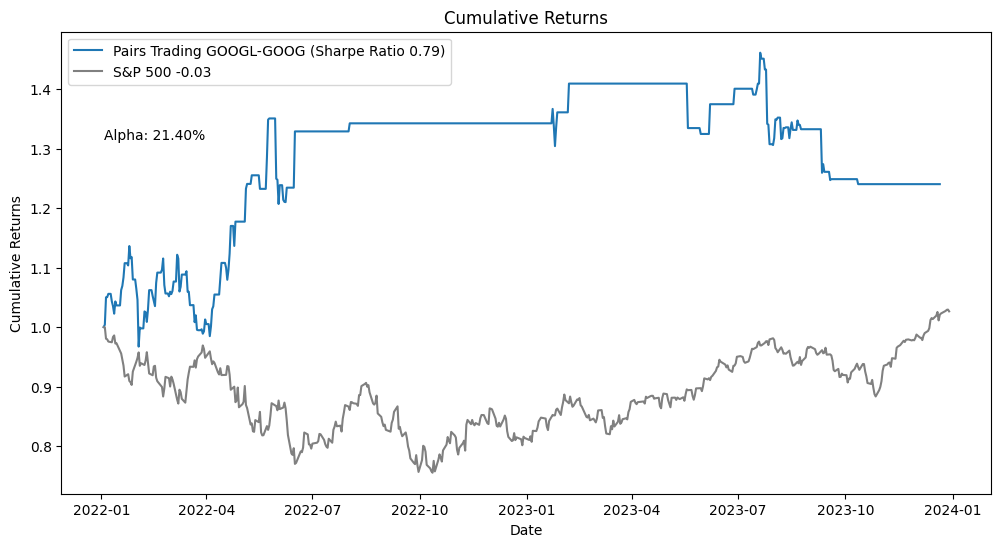

In [ ]:
# Set thresholds based on previously identified best values
exit_threshold = highest_returns_exit
entry_threshold = highest_returns_entry

# Generate trading signals for past and backtest data using the selected thresholds
data_past = generate_signals(data_past, spread_past, entry_threshold, exit_threshold)
data_backtest = generate_signals(data_backtest, spread_backtest, entry_threshold, exit_threshold)

# Backtest the strategy on backtest data and plot cumulative returns
cumprod, strategy_returns = backtest(data_backtest, plot=True)

# Calculate alpha
alpha = cumprod.iloc[-1] - baseline_cumrets_backtest.iloc[-1]

# Plot baseline cumulative returns (S&P 500) for comparison
plt.plot(baseline_cumrets_backtest, label=f'S&P 500 {baseline_sr_backtest}', c='gray')
plt.text(x=baseline_cumrets_backtest.index.min(), y=max(cumprod.max(), baseline_cumrets_backtest.max()) * 0.9, s=f'Alpha: {alpha:.2%}')
plt.legend()
plt.show()

# Backtest: Highest Sharpe Ratio Strategy (Test Set)

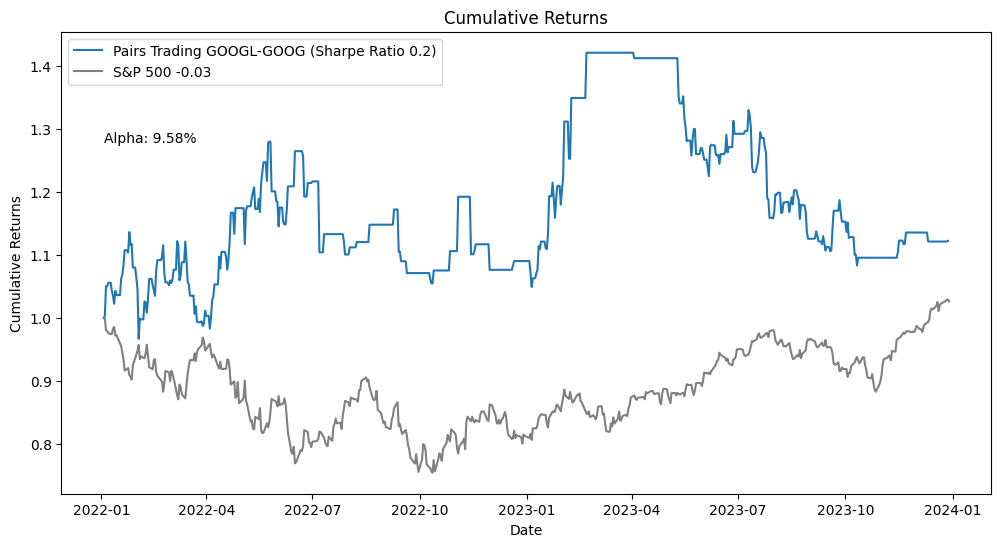

In [ ]:
# Set thresholds based on highest Sharpe ratio values
exit_threshold = highest_sr_exit
entry_threshold = highest_sr_entry

# Generate trading signals for past and backtest data using the selected thresholds
data_past = generate_signals(data_past, spread_past, entry_threshold, exit_threshold)
data_backtest = generate_signals(data_backtest, spread_backtest, entry_threshold, exit_threshold)

# Backtest the strategy on backtest data and plot cumulative returns
cumprod, strategy_returns = backtest(data_backtest, plot=True)

# Calculate alpha
alpha = cumprod.iloc[-1] - baseline_cumrets_backtest.iloc[-1]

# Plot baseline cumulative returns (S&P 500) for comparison
plt.plot(baseline_cumrets_backtest, label=f'S&P 500 {baseline_sr_backtest}', c='gray')
plt.text(x=baseline_cumrets_backtest.index.min(), y=max(cumprod.max(), baseline_cumrets_backtest.max()) * 0.9, s=f'Alpha: {alpha:.2%}')
plt.legend()
plt.show()

# References
1. [An Introduction to Cointegration for Pairs Trading](https://hudsonthames.org/an-introduction-to-cointegration/)
2. [Pairs trade - Wikipedia](https://en.wikipedia.org/wiki/Pairs_trade)
3. [Alphabet’s GOOG vs. GOOGL: What’s the Difference?](https://www.investopedia.com/ask/answers/052615/whats-difference-between-googles-goog-and-googl-stock-tickers.asp)